In [1]:
## From: https://towardsdatascience.com/web-scraping-craigslist-a-complete-tutorial-c41cea4f4981

#import get to call a get request on the site
from requests import get

#get the first page of the housing prices
response = get('https://minneapolis.craigslist.org/search/apa?hasPic=1&availabilityMode=0') #get rid of those lame-o's that post a housing option without a pic using their filter

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print( len(posts)) #to double check I got 120 (elements/page)
post = posts[0]

<class 'bs4.element.ResultSet'>
120


In [2]:
print(post)

<li class="result-row" data-pid="7137253237" data-repost-of="5616822895">
<a class="result-image gallery" data-ids="1:00s0s_a9OFfa77qnU,1:00J0J_4KDhr7VQaZV,1:00Y0Y_kIZKwJCKwHk,1:00A0A_le7Y6OqYXPm,1:00i0i_drVYzJ48TZT,1:01616_4ybqIH6SrmS,1:00n0n_6yIR1PJfIjl,1:00i0i_2YyECpD1eeu,1:00N0N_9f9I5F4ANhP,1:00B0B_5rVnDkvzG8F,1:00k0k_28LM8zdpic7,1:00z0z_lbok4DOD1Up,1:00E0E_gTHfOWyD0LG,1:00s0s_33OFmxHhR23,1:00G0G_fj5naSGDJ57" href="https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-2-bedroom-apartment-in/7137253237.html">
<span class="result-price">$1100</span>
</a>
<p class="result-info">
<span class="icon icon-star" role="button">
<span class="screen-reader-text">favorite this post</span>
</span>
<time class="result-date" datetime="2020-06-09 07:08" title="Tue 09 Jun 07:08:46 AM">Jun  9</time>
<a class="result-title hdrlnk" data-id="7137253237" href="https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-2-bedroom-apartment-in/7137253237.html">2 Bedroom Apartment in Northeast Minneapolis<

In [3]:
curtime = post.find('time',class_='result-date')['datetime']
print(curtime)
cururl = post.find('a',class_='result-title hdrlnk')['href']
print(cururl)

2020-06-09 07:08
https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-2-bedroom-apartment-in/7137253237.html


In [4]:
#curbrs = post.find('span', class_ = 'housing').text.split()[0][:-2]
#print(curbrs)

#cursqft = post.find('span', class_ = 'housing')
#if cursqft:
#    cursqft = cursqft.text.split()[2][:-3] #cleans the ft2 at the end
#    print(cursqft)
#print(cursqft)

curhood = post.find('span', class_='result-hood') 
if curhood:
    curhood = curhood.text
    print(curhood)



 (minneapolis)


In [5]:
from geopy.geocoders import Nominatim, ArcGIS
curmap = BeautifulSoup(get(cururl).text,'html.parser').find_all('div',class_='mapbox')[0]
geolocator = Nominatim(user_agent="darren")

print(curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])

location = geolocator.reverse(query=curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])


geolocator2 = ArcGIS(user_agent="darren")
location2 = geolocator2.reverse(query=curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'],
                                distance=500)





import numpy as np

loc = geolocator.reverse(query=str(np.round(float(curmap.find('div')['data-latitude'])-.001,3))
                   +","
                   +str(np.round(float(curmap.find('div')['data-longitude'])-.001,3)))
    
print(location.address)
print(location2.address)
print(loc.address)

#print(location.raw['address'])
#print(location.raw['address']['city'])
#print(location.raw['address']['neighbourhood'])
#print(location.raw['address']['postcode'])

45.009995,-93.257965
Northeast 22nd Avenue, Holland, Northeast, Minneapolis, Hennepin County, Minnesota, 55418, United States of America
616 NE 22nd Ave, Minneapolis, Minnesota 55418, USA
573, Northeast 20th Avenue, Holland, Northeast, Minneapolis, Hennepin County, Minnesota, 55418, United States of America


In [6]:
curpost = get(post.find('a', class_='result-title hdrlnk')['href']).text
curmap = BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')
print(curmap)

[<div class="mapbox">
<div class="viewposting" data-accuracy="10" data-latitude="45.009995" data-longitude="-93.257965" id="map"></div>
<div class="mapaddress">2200 7th street ne</div>
<p class="mapaddress">
<small>
            (<a href="https://www.google.com/maps/search/45.009995,-93.257965" target="_blank">google map</a>)
        </small>
</p>
</div>]


In [7]:
#new code to put here:
#get list of neighborhoods
#for each neighborhood,
#  get central coordinate
#for each posting
#  calculate distance from neighborhoods' centers
#  assign neighborhood based on nearest neighbor

In [8]:
#linkpfx = 'https://minneapolis.craigslist.org/search/apa?'
#linksfx =( 'sort=date'
#          +'&hasPic=1'
#          +'&bundleDuplicates=1'
#          +'&search_distance=20'
#          +'&postal=55454'
#          +'&min_price=500'
#          +'&max_price=4000'
#          +'&max_bedrooms=3'
#          +'&availabilityMode=0'
#          +'&sale_date=all+dates')
#response = get(linkpfx+linksfx)
#html_soup = BeautifulSoup(response.text, 'html.parser')
#results_num = html_soup.find('div', class_= 'search-legend')
#results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array
#pages = np.arange(0, results_total+1, 120)
#print(results_total)
#print(pages)

In [51]:
#build out the loop
from bs4 import BeautifulSoup
from time import sleep, time
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from IPython.core.display import clear_output
import numpy as np


citystr = 'minneapolis' ## 'washingtondc' #'minneapolis'
linkpfx = 'https://'+citystr+'.craigslist.org/search/apa?'
linksfx =( 'sort=date'
          +'&hasPic=1'
          +'&bundleDuplicates=1'
          +'&search_distance=20'
          +'&postal=55454' #55454' #DC: 20009
          +'&min_price=300'
          +'&max_price=8000'
          +'&max_bedrooms=4'
          +'&availabilityMode=0'
          +'&sale_date=all+dates')
response = get(linkpfx+linksfx)
html_soup = BeautifulSoup(response.text, 'html.parser')
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array
pages = np.arange(0, results_total+1, 120)


from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="derinkuyu",timeout=5)

#
TypeDict = {
    'apartment': 1, 
    'condo':2, 
    'cottage/cabin':3, 
    'duplex':4, 
    'flat':5, 
    'house':6, 
    'in-law':7, 
    'loft':8, 
    'townhouse':9, 
    'manufactured':10, 
    'assisted living':11, 
    'land':12}
LaundryDict = {
    'w/d in unit':1,
    'w/d hookups':2,
    'laundry in bldg':3,
    'laundry on site':4,
    'no laundry on site':5
}    
ParkingDict = {
    'carport':1,
    'attached garage':2,
    'detached garage':3,
    'off-street parking':4,
    'street parking':5,
    'valet parking':6,
    'no parking':7
}

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []


cities = []
towns = []
neighborhoods = []
zips = []


types = []
laundries = []
parkings = []

for page in pages:
    
    #get request
    response = get(linkpfx
                   + 's=' #parameter for defining page number
                   + str(page) #page in above array
                   + linksfx)    
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:
        #sleep(1.1)
        
        curpost = get(post.find('a', class_='result-title hdrlnk')['href']).text
        curmap = BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')
        
        if (post.find('span', class_ = 'result-hood') is not None) and curmap:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #
            #curpost = get(post_link).text
            curmap = curmap[0] #BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')[0]
            location = geolocator.reverse(curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])
            
            try: 
                cities.append(location.raw['address']['city'])
            except:
                try: 
                    cities.append(location.raw['address']['town'])
                except:
                    cities.append('')
            
            try: 
                towns.append(location.raw['address']['town'])
            except:
                towns.append('')
            
            try:
                neighborhoods.append(location.raw['address']['neighbourhood'])
            except:
                try: 
                    locshift1 = geolocator.reverse( str(float(curmap.find('div')['data-latitude'])+.001)+","+str(float(curmap.find('div')['data-longitude'])+.001))
                    neighborhoods.append(locshift1.raw['address']['neighbourhood'])
                except:                   
                    try: 
                        locshift2 = geolocator.reverse( str(float(curmap.find('div')['data-latitude'])-.001)+","+str(float(curmap.find('div')['data-longitude'])-.001))
                        neighborhoods.append(locshift2.raw['address']['neighbourhood'])
                    except:
                        try:
                            neighborhoods.append(location.raw['address']['town'])
                        except:
                            try:
                                neighborhoods.append(location.raw['address']['city'])
                            except:
                                neighborhoods.append('')
            
            try:
                zips.append(location.raw['address']['postcode'])
            except:
                zips.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                typename = list(set(curattr.text.split('\n')).intersection(list(TypeDict.keys())))[0]
                types.append(TypeDict[typename])
            except:
                types.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                laundryname = list(set(curattr.text.split('\n')).intersection(list(LaundryDict.keys())))[0]
                laundries.append(LaundryDict[laundryname])
            except:
                laundries.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                parkname = list(set(curattr.text.split('\n')).intersection(list(ParkingDict.keys())))[0]
                parkings.append(ParkingDict[parkname])
            except:
                parkings.append('')
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            post_price = int(post.a.text.strip().replace("$", "")) 
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

import pandas as pd

apts = pd.DataFrame({
    'posted': post_timing,
    'neighborhood': post_hoods,
    'post title': post_title_texts,
    'number bedrooms': bedroom_counts,
    'sqft': sqfts,
    'URL': post_links,
    'price': post_prices,
    'cities':cities,
    'towns':towns,
    'neighborhoods':neighborhoods,
    'zips': zips,
    'types':types,
    'parking':parkings,
    'laundry':laundries})
#print(apts.info())
#apts.head(30)
apts.shape

#drop duplicates
apts = apts.drop_duplicates(subset=['URL','sqft','number bedrooms'])

#make the number bedrooms to a float (since np.nan is a float too)
apts['number bedrooms'] = apts['number bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to be able to work with it
from datetime import datetime

apts['posted'] = pd.to_datetime(apts['posted'])

#Looking at what neighborhoods there are with apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

##remove the parenthesis from the left and right of the neighborhoods
#apts['neighborhood'] = apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))
#
##titlecase them
#apts['neighborhood'] = apts['neighborhood'].str.title()
#
##just take the first name of the neighborhood list, splitting on the '/' delimiter
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.split('/')[0])
#
##fix one-offs that
#apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
#apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)
#
##remove whitespaces
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.strip())

#save the clean data

apts.to_csv(path_or_buf='./apts_'+citystr+"_"+str(datetime.now()).replace(' ','_').replace(':','-')+'.csv', index=False)
apts.shape


Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!
Page 9 scraped successfully!
Page 10 scraped successfully!
Page 11 scraped successfully!
Page 12 scraped successfully!
Page 13 scraped successfully!
Page 14 scraped successfully!
Page 15 scraped successfully!
Page 16 scraped successfully!
Page 17 scraped successfully!
Page 18 scraped successfully!
Page 19 scraped successfully!
Page 20 scraped successfully!
Page 21 scraped successfully!
Page 22 scraped successfully!
Page 23 scraped successfully!
Page 24 scraped successfully!
Page 25 scraped successfully!
Page 26 scraped successfully!


Scrape complete!


(86, 14)

In [52]:
##drop duplicates
#apts = apts.drop_duplicates(subset=['URL','sqft','number bedrooms'])
#
##make the number bedrooms to a float (since np.nan is a float too)
#apts['number bedrooms'] = apts['number bedrooms'].apply(lambda x: float(x))
#
##convert datetime string into datetime object to be able to work with it
#from datetime import datetime
#
#apts['posted'] = pd.to_datetime(apts['posted'])

#Looking at what neighborhoods there are with apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

##remove the parenthesis from the left and right of the neighborhoods
#apts['neighborhood'] = apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))
#
##titlecase them
#apts['neighborhood'] = apts['neighborhood'].str.title()
#
##just take the first name of the neighborhood list, splitting on the '/' delimiter
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.split('/')[0])
#
##fix one-offs that
#apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
#apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)
#
##remove whitespaces
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.strip())

#save the clean data

#apts.to_csv(path_or_buf='./apts_'+str(datetime.now()).replace(' ','_').replace(':','-')+'.csv', index=False)
#apts.shape

In [54]:
import os
import glob
citystr = 'minneapolis' #'minneapolis', 'washingtondc'

aptfiles = glob.glob('apts_'+citystr+'*')


try:
    del apts
except:
    print('no apts in memory, loading some...')


for file in aptfiles:
    try: 
        apts = apts.append(pd.read_csv(file),ignore_index=True)
    except:
        apts = pd.read_csv(file)
apts = apts.drop_duplicates(subset=['URL','sqft','number bedrooms'])
apts.shape

(1165, 14)

In [55]:
print(apts.neighborhoods)

0          Burnsville
1        East Calhoun
2          Burnsville
3       Phillips West
4         Bloomington
            ...      
1617       Burnsville
1618          Hopkins
1619        Kingfield
1620          Newport
1621          Hilltop
Name: neighborhoods, Length: 1165, dtype: object


In [56]:
apts.describe()

,number bedrooms,sqft,price,types,parking,laundry
count,1147.000000,1026.000000,1165.000000,1158.000000,982.000000,1052.000000
mean,1.761116,1014.896686,1398.740773,1.976684,2.928717,2.135932
std,0.786306,487.300077,493.230099,2.217704,1.052646,1.144033
min,1.000000,103.000000,399.000000,1.000000,1.000000,1.000000
25%,1.000000,730.000000,1050.000000,1.000000,2.000000,1.000000
50%,2.000000,899.000000,1325.000000,1.000000,3.000000,3.000000
75%,2.000000,1191.500000,1649.000000,1.000000,4.000000,3.000000
max,5.000000,8500.000000,3984.000000,9.000000,7.000000,5.000000


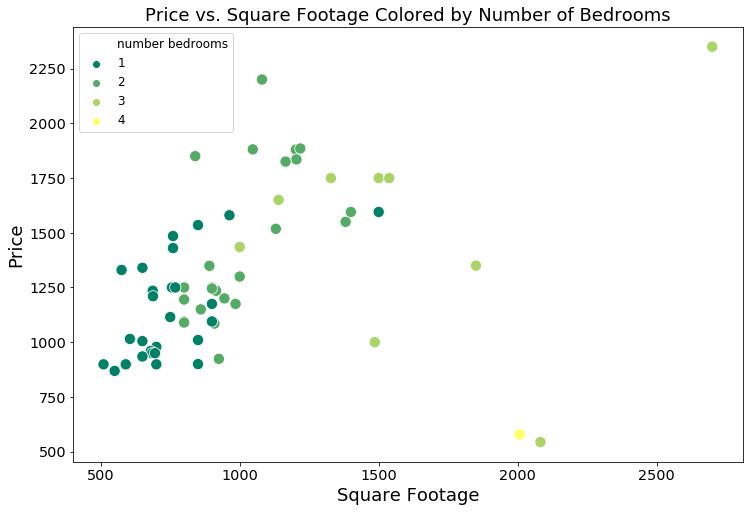

In [57]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.scatterplot(x='sqft', y='price', hue='number bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Square Footage", fontsize=18)
plt.ylabel("Price", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);


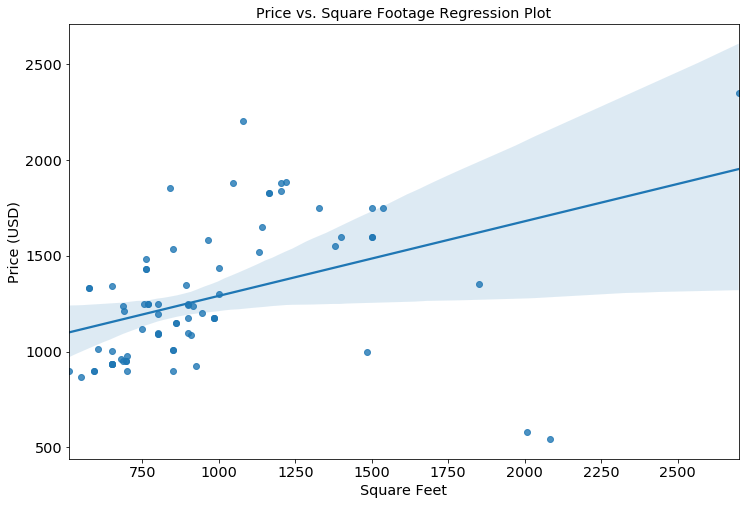

In [58]:
plt.figure(figsize=(12, 8))
sns.regplot(x='sqft', y='price', data=apts.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Square Feet");
plt.ylabel("Price (USD)");

In [59]:
apts.corr()

,number bedrooms,sqft,price,types,parking,laundry
number bedrooms,1.000000,0.691416,0.356033,0.442592,-0.078723,-0.173643
sqft,0.691416,1.000000,0.440539,0.470856,-0.152769,-0.216438
price,0.356033,0.440539,1.000000,0.145077,-0.312611,-0.486296
types,0.442592,0.470856,0.145077,1.000000,-0.160587,-0.255593
parking,-0.078723,-0.152769,-0.312611,-0.160587,1.000000,0.531300
laundry,-0.173643,-0.216438,-0.486296,-0.255593,0.531300,1.000000


In [60]:
apts[apts['number bedrooms']<=1].groupby('neighborhoods').median()

,number bedrooms,sqft,price,types,parking,laundry
neighborhoods,,,,,,
Anoka,1.0,NaN,895.0,1.0,4.0,NaN
Apple Valley,1.0,900.0,1135.0,4.5,2.0,2.5
Aquila,1.0,815.0,1025.0,1.5,3.5,3.0
Audubon Park,1.0,800.0,890.0,2.0,2.0,3.0
Avenida,1.0,1342.0,1885.0,9.0,2.0,1.0
...,...,...,...,...,...,...
West St. Paul,1.0,750.0,1099.0,1.0,2.0,3.0
Whittier,1.0,560.0,1025.0,1.0,4.0,3.0
Willow Park,1.0,666.5,1435.0,1.0,2.0,1.0


In [61]:
#correct oddly named locations
apts['neighborhoods'].replace('Uptown Minneapolis', 'Uptown', inplace=True)

apts[apts['number bedrooms']<=1].groupby('neighborhoods').median()['price'].sort_values()

neighborhoods
McKinley            600.0
Northeast Park      650.0
Victory             650.0
Powderhorn Park     700.0
Logan Park          750.0
                    ...  
Sheridan           1595.0
St Anthony East    1603.0
East Calhoun       1650.0
Blackstone         1693.0
Avenida            1885.0
Name: price, Length: 83, dtype: float64

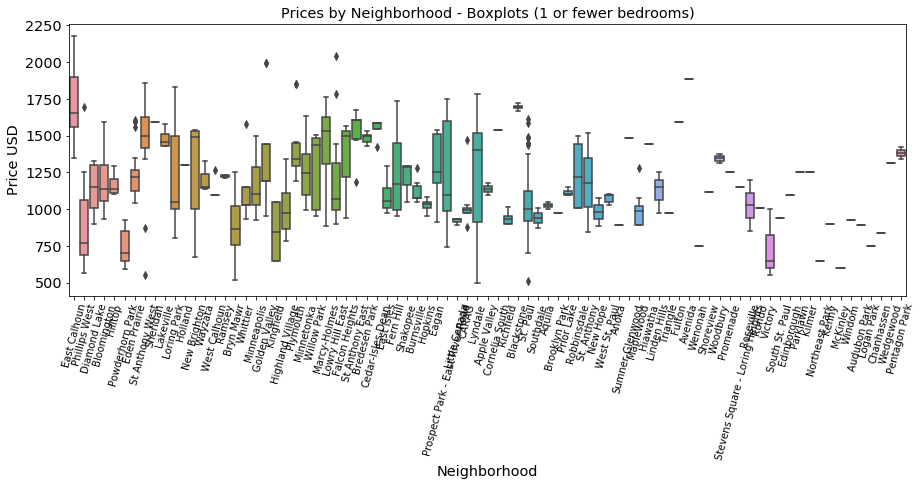

In [62]:
brlim = 1
sns.boxplot(x='neighborhoods', y='price', data=apts[apts['number bedrooms']<=brlim])
plt.xlabel("Neighborhood");
plt.xticks(rotation=75,size=10)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots ("+str(brlim)+" or fewer bedrooms)");

In [68]:
# drop problematic cols
apts = apts.dropna(subset=['price','number bedrooms','sqft','neighborhoods','types','laundry','parking'])
print(apts.shape)

# recode neighborhoods
apts_onehot = apts.copy()
apts_onehot = pd.get_dummies(apts_onehot, columns=['cities'], prefix = ['ct'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['neighborhoods'], prefix = ['nb'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['types'], prefix = ['ty'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['laundry'], prefix = ['ld'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['parking'], prefix = ['pk'])

print(apts_onehot)

(854, 14)
                   posted  \
0     2020-06-04 13:48:00   
1     2020-06-04 13:47:00   
2     2020-06-04 13:46:00   
3     2020-06-04 13:46:00   
4     2020-06-04 13:44:00   
...                   ...   
1617  2020-06-09 13:41:00   
1618  2020-06-09 13:38:00   
1619  2020-06-09 13:38:00   
1620  2020-06-09 13:38:00   
1621  2020-06-09 13:36:00   

                                                       neighborhood  \
0                           (12212 Oak Leaf Circle, Burnsville, MN)   
1                                                          (Uptown)   
2      (South metro, close to the airport and downtown Minneapolis)   
3                                                     (Elliot Park)   
4                                                (35W, Bloomington)   
...                                                             ...   
1617                                            (Southwind Village)   
1618                                        (Hopkins / Minneapolis)   
16

In [69]:
from sklearn import linear_model

maincols = ['number bedrooms','sqft']
nbcols = [col for col in apts_onehot if col.startswith('ct')]
for c in nbcols:
    maincols.append(c) 
nbcols = [col for col in apts_onehot if col.startswith('nb')]
for c in nbcols:
    maincols.append(c) 
tycols = [col for col in apts_onehot if col.startswith('ty')]
for c in nbcols:
    maincols.append(c) 
pkcols = [col for col in apts_onehot if col.startswith('pk')]
for c in nbcols:
    maincols.append(c) 
ldcols = [col for col in apts_onehot if col.startswith('ld')]
for c in nbcols:
    maincols.append(c) 

# set up regression
y = apts_onehot['price'].values.reshape(-1,1)
X = apts_onehot[maincols].values
thresh = .5 # drop columns that correlate above this value
cor = np.abs(np.corrcoef(X.T))
p = np.argwhere(np.triu(np.isclose(cor,1),1))
X = np.delete(X,p[:,1],axis=1)

#OLS
reg = linear_model.LinearRegression()
reg.fit(y=y,X=X)
apts_onehot['price_est'] = np.zeros((apts_onehot.shape[0],1))
apts_onehot['price_est'] = reg.predict(X)
apts_onehot['price_dif'] = apts_onehot['price']-apts_onehot['price_est']
apts_onehot['price_difpct'] = (apts_onehot['price_dif'] / apts_onehot['price_est']) * 100

# Ridge regression approach
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge = Ridge()
parameters = {'alpha': [.005, .01, .05, .10, 1, 5, 10, 20, 40, 50,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error',cv=10)
ridge_regressor.fit(X=X,y=y)
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)
apts_onehot['price_est'] = ridge_regressor.predict(X)
apts_onehot['price_dif'] = apts_onehot['price']-apts_onehot['price_est']
apts_onehot['price_difpct'] = (apts_onehot['price_dif'] / apts_onehot['price_est']) * 100


{'alpha': 5}
-171011.176424201


In [70]:
X.shape

(854, 136)

In [71]:
apts_onehot['price_difpct']

0       -4.198785
1       -1.282127
2       -3.789702
3       32.048282
4        3.792525
          ...    
1617     9.077043
1618    -3.804695
1619   -10.371807
1620   -31.518706
1621    -1.897044
Name: price_difpct, Length: 854, dtype: float64

In [73]:
pd.options.display.max_colwidth = 200

apts_onehot[apts_onehot['price_difpct']<=-30].sort_values('price_difpct',ascending=True)['URL'] 

1350      https://minneapolis.craigslist.org/wsh/apa/d/minneapolis-all-amenities-under-1-roof/7137895118.html
660          https://minneapolis.craigslist.org/wsh/apa/d/minneapolis-fne-dnng-spacous-home-d/7133061709.html
645       https://minneapolis.craigslist.org/ram/apa/d/minneapolis-super-clean-beautiful-open/7129177753.html
659          https://minneapolis.craigslist.org/csw/apa/d/minneapolis-fne-dnng-spacous-home-d/7133063641.html
17            https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-chrming-house-band-new/7133058520.html
644       https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-super-clean-beautiful-open/7129175541.html
1348      https://minneapolis.craigslist.org/csw/apa/d/minneapolis-all-amenities-under-1-roof/7137895140.html
1022      https://minneapolis.craigslist.org/ram/apa/d/saint-paul-spacious-bright-3-bedroom-1/7137274429.html
552         https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-south-facing-renovated-2/7134577076.html
1305      